
<font size="5">**<center> ĐỒ ÁN CUỐI KỲ </center>** </font>

<font size="4">**<center> kHOA HỌC DỮ LIỆU ỨNG DỤNG</center>** </font>

# I/ Thông tin nhóm:

| STT |       Tên       |   MSSV  |
|-----|:---------------:|--------:|
|  1  |   Thái Bá Sơn   | 1712732 |
|  2  | Huỳnh Công Sinh | 1712724 |

# II/ Khai thác dữ liệu:

In [1]:
from selenium import webdriver
import time
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd


Dữ liệu khai thác từ: [đây](https://www.nasdaq.com/) 

Cấu trúc câu lệnh khai thác: 'https://www.nasdaq.com/market-activity/stocks/' + 'stock_code' + '/historical'


# I/ Dữ liệu

### Thông tin về dữ liệu:


Trong sổ tay này, chúng ta sẽ xem xét dữ liệu từ thị trường chứng khoán, đặc biệt là một số cổ phiếu công nghệ. Sử dụng pandas để lấy thông tin cổ phiếu, hình dung các khía cạnh khác nhau của nó và cuối cùng ta sẽ xem xét một số cách phân tích rủi ro của cổ phiếu, dựa trên lịch sử hoạt động trước đó của nó. Chúng tôi cũng sẽ dự đoán giá cổ phiếu trong tương lai thông qua phương pháp Long Short Term Memory (LSTM)! 

**Nguồn:**

---

# II/ Khám phá dữ liệu:

### Import

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

### Đọc dữ liệu từ file csv vào dataframe

In [3]:
df = pd.read_csv("stock_data.csv", sep = '\t')
df.head()

,Date,Close/Last,Volume,Open,High,Low,Company
0,12/22/2020,$1720.22,1018829,$1729.33,$1732.6123,$1705.78,Alphabet
1,12/21/2020,$1734.56,1698707,$1709.13,$1737,$1694,Alphabet
2,12/18/2020,$1726.22,4262837,$1746.17,$1748.36,$1715,Alphabet
3,12/17/2020,$1740.51,1744005,$1763.93,$1766.71,$1731.15,Alphabet
4,12/16/2020,$1757.19,1233836,$1769.11,$1769.11,$1749.06,Alphabet


### Thông tin thuộc tính:

In [4]:
num_rows, num_cols = df.shape
print("Dữ liệu có {} dòng, {} cột.".format(num_rows, num_cols))

Dữ liệu có 14734 dòng, 7 cột.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14734 entries, 0 to 14733
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         14734 non-null  object
 1    Close/Last  14734 non-null  object
 2    Volume      14734 non-null  int64 
 3    Open        14734 non-null  object
 4    High        14734 non-null  object
 5    Low         14734 non-null  object
 6   Company      14734 non-null  object
dtypes: int64(1), object(6)
memory usage: 805.9+ KB


---

## Tiền xử lý:

- Kiểm tra dữ thông tin dữ liệu: kiểu dữ liệu của các thuộc tính, các cột có bị thiếu giá trị hay không?...

In [6]:
#xem thông tin data:
df.info()

if df.isnull().values.any() == False:
    print("=> Không có ô giá trị nào bị thiếu.")
else:
    print("Dữ liệu bị thiếu.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14734 entries, 0 to 14733
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         14734 non-null  object
 1    Close/Last  14734 non-null  object
 2    Volume      14734 non-null  int64 
 3    Open        14734 non-null  object
 4    High        14734 non-null  object
 5    Low         14734 non-null  object
 6   Company      14734 non-null  object
dtypes: int64(1), object(6)
memory usage: 805.9+ KB
=> Không có ô giá trị nào bị thiếu.


- Định dạng lại kiểu dữ liệu cho phù hợp.

In [7]:
df = pd.read_csv("stock_data.csv", sep = '\t')

#Định dạng lại cột Date sang kiểu dữ liệu datetime
df["Date"] = pd.to_datetime(df["Date"])
#Xóa khoảng trắng trong dữ liệu:
df.columns = df.columns.str.replace(' ', '') 
df.replace(' ', '', regex=True, inplace = True)

#Chuyển cột có ký hiệu tiền tệ ($) sang dạng datetime:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)

#Sắp xếp cổ phiếu tăng dần theo ngày:
df.sort_values(['Company', 'Date'], ascending=[True, True], inplace = True)

company_name = list(df["Company"].unique())

- Thêm ngày bị thiếu:

In [8]:
data = pd.DataFrame(columns=df.columns)
companies = df['Company'].unique()
for company in companies:
    one_company_df = df[df['Company'] == company]
    one_company_df['Date'] = pd.to_datetime(one_company_df['Date'])
    one_company_df = one_company_df.sort_values(by=['Date'], ascending=True)
    one_company_df.set_index('Date', inplace=True)
    one_company_df = one_company_df.resample('D').bfill().reset_index()
    one_company_df = one_company_df.sort_values(by=['Date'], ascending=False).reset_index()
    data = data.append(one_company_df)
data = data.drop('index', axis=1).reset_index(drop=True)

<ipython-input-8-6af9892faa15>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_company_df['Date'] = pd.to_datetime(one_company_df['Date'])


- Dữ liệu sau khi tiền xử lý:

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21376 entries, 0 to 21375
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        21376 non-null  datetime64[ns]
 1   Close/Last  21376 non-null  float64       
 2   Volume      21376 non-null  object        
 3   Open        21376 non-null  float64       
 4   High        21376 non-null  float64       
 5   Low         21376 non-null  float64       
 6   Company     21376 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.1+ MB


,Date,Close/Last,Volume,Open,High,Low,Company
0,2020-12-22,1720.22,1018829,1729.33,1732.6123,1705.78,Alphabet
1,2020-12-21,1734.56,1698707,1709.13,1737.0000,1694.00,Alphabet
2,2020-12-20,1734.56,1698707,1709.13,1737.0000,1694.00,Alphabet
3,2020-12-19,1734.56,1698707,1709.13,1737.0000,1694.00,Alphabet
4,2020-12-18,1726.22,4262837,1746.17,1748.3600,1715.00,Alphabet


In [10]:
# Summary Stats
data.describe()

,Close/Last,Open,High,Low
count,21376.000000,21376.000000,21376.000000,21376.000000
mean,336.354891,336.165136,339.832536,332.419078
std,527.614211,527.359682,533.480370,521.094802
min,4.366000,4.356000,4.454000,4.222000
25%,38.936250,38.840625,39.320000,38.332500
50%,94.525000,94.990000,96.105000,93.716250
75%,358.702500,358.633750,361.830925,354.485000
max,3531.450000,3547.000000,3552.250000,3486.685000


In [11]:
100 * data.isnull().sum() / len(df)

Date          0.0
Close/Last    0.0
Volume        0.0
Open          0.0
High          0.0
Low           0.0
Company       0.0
dtype: float64

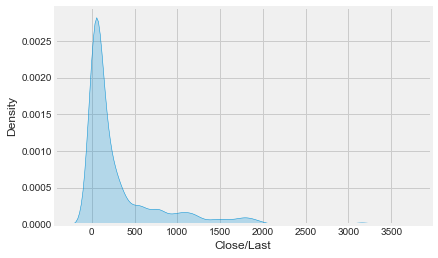

In [12]:
sns.kdeplot(df['Close/Last'], shade=True)
plt.show()

# III/ Đặt câu hỏi:
- 1.

- 2. 

- 3.

- 4. 

- 5. 


---

# IV/ Tìm câu trả lời:

- **<font color=red> 1. Liệu trình độ học vấn của cha mẹ có quyết định đến thành tích học tập của con ở trường hay không? </font>**

Để giải quyết câu hỏi này, ta cần quan tâm đến 3 cột thuộc tính **Medu**, **Fedu** và **Grade**. 

Tạo hàm <font color=blue> percent_family_edu </font>(data) với đầu vào là data đang xét, xuất một Series với Index là học vấn của cha mẹ và Values là phần trăm có con đạt điểm A.

In [13]:
def get_records_in_time_period(df, company_name, start_date, end_date):
    company_df = df[df['Company'] == company_name]
    time_period_filter = (company_df['Date'] >= start_date) & (company_df['Date'] <= end_date)
    return company_df.loc[time_period_filter]


k = get_records_in_time_period(data, 'Apple', '2019-12-1', '2020-12-1')

In [14]:
def lstm_model(df, company_name, input_len=100):
    stock = df[df['Company'] == company_name]['Close/Last'].values
    stock = stock.reshape(len(stock), 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_stock = scaler.fit_transform(stock)

    train_values = scaled_stock[:int(len(stock) * 0.8)]
    X_train, Y_train = [], []

    for i in range(input_len, len(train_values)):
        X_train.append(train_values[i - 100:i])
        Y_train.append(train_values[i])

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, batch_size=1, epochs=1)

    return model


In [15]:
data[data['Company'] == 'Amazon']

,Date,Close/Last,Volume,Open,High,Low,Company
3647,2020-12-22,3206.52,2381781,3202.843,3222.0000,3180.08,Amazon
3648,2020-12-21,3206.18,3836846,3200.010,3226.9666,3166.00,Amazon
3649,2020-12-20,3206.18,3836846,3200.010,3226.9666,3166.00,Amazon
3650,2020-12-19,3206.18,3836846,3200.010,3226.9666,3166.00,Amazon
3651,2020-12-18,3201.65,5995713,3243.990,3249.4200,3171.60,Amazon
...,...,...,...,...,...,...,...
7289,2011-01-02,184.22,5324837,181.370,186.0000,181.21,Amazon
7290,2011-01-01,184.22,5324837,181.370,186.0000,181.21,Amazon
7291,2010-12-31,180.00,3449215,181.960,182.3000,179.51,Amazon
7292,2010-12-30,182.75,1960269,183.920,184.5500,182.75,Amazon


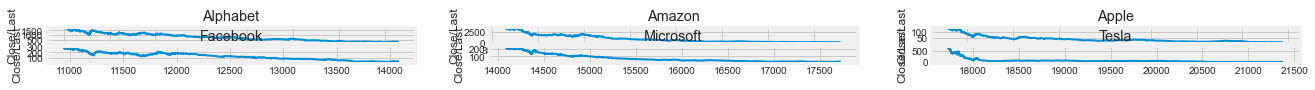

In [16]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_name, 1):
    plt.subplot(2, 3, i)
    data[data['Company'] == company]['Close/Last'].plot(linewidth=2.0)
    plt.ylabel('Close/Last')
    plt.xlabel(None)
    plt.title(f"{company_name[i - 1]}")

\- Trực quan kết quả bằng biểu đồ cột:

**Kết luận:** Dựa vào biểu đồ trên, ta thấy biểu đồ có xu hướng tăng dần qua các mốc học vấn của cha mẹ, có thể nói cha mẹ càng có học vấn cao thì con của họ càng giỏi. Kết quả này thu được có thể do gen di truyền từ bố mẹ và môi trường học tập mà con cái nhận được sự quan tâm, chỉ bảo từ gia đình. 

---

---

- **<font color=red> 2. Tạo mô hình huấn luyện để dự đoán giá</font>**

Để tạo mô hình huấn luyện, bước đầu tiên ta cần phải chuẩn bị dữ liệu cho mô hình. Ở đây, ta sẽ làm việc với cột giá trị stock lúc đóng phiên giao dịch của Alphabet. Sau đó chuẩn hóa dữ liệu bằng `MinMaxScaler` của sklearn. 

In [17]:
alpha_stock = df[df['Company'] == 'Alphabet']['Close/Last'].values
alpha_stock = alpha_stock.reshape(len(alpha_stock), 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock = scaler.fit_transform(alpha_stock)
scaled_stock

array([[0.04019269],
       [0.03951071],
       [0.03795231],
       ...,
       [0.93770057],
       [0.94296211],
       [0.93391529]])

Với dữ liệu này, ta lấy 20% dòng cuối để làm giá trị test, còn lại ta dùng cho việc huấn luyện mô hình.

In [18]:
train_values = scaled_stock[:int(len(alpha_stock) * 0.8)]
train_values

array([[0.04019269],
       [0.03951071],
       [0.03795231],
       ...,
       [0.49441885],
       [0.4740225 ],
       [0.4698713 ]])

Sau đó, tạo ra tập X_train và Y_train.
- Với Y_train, ta lấy giá trị stock của một ngày.
- Với X_train, ta lấy giá trị của 60 dòng trước ngày đó.

In [19]:
X_train, Y_train = [], []

for i in range(120, len(train_values)):
    X_train.append(train_values[i - 120:i])
    Y_train.append(train_values[i])

In [20]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Bắt đầu xây dựng mô hình huấn luyện.

In [21]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

1891/1891 [==============================] - 54s 27ms/step - loss: 0.0016 0s - loss


Sau khi tạo và huấn luyện mô hình cho tập huấn luyện, ta tạo dữ liệu cho tập test.

In [22]:
test_values = scaled_stock[int(len(alpha_stock) * 0.8) - 120:]

In [23]:
X_test = []
Y_test = alpha_stock[int(len(alpha_stock) * 0.8):, :]

for i in range(120, len(test_values)):
    X_test.append(test_values[i - 120:i])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))


Áp dụng mô hình cho tập dữ liệu test.

In [24]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Tính độ lỗi RMSE cho tập dự đoán và tập test.

In [25]:
rmse = np.sqrt(np.mean(((predictions - Y_test) ** 2)))
rmse

49.871842101818636